In [1]:
from collections import defaultdict
import itertools as it
import numpy as np

from adict import adict

In [2]:
def x(i, j):
    """Variable label"""
    return f"x{i}_{j}"

def ind(var: str):
    """Return position indices from variable label"""
    i, j = var[1:].split('_')
    return (int(i), int(j))

def array_to_sample(array: np.array):
    """Transform solution given as np.array to dict."""
    return {
        x(i, j): value
        for (i, j), value in np.ndenumerate(array)
    }

def to_grid(dictionary):
    """Convert annealing sample (dict) to np.array."""
    star_positions = [ind(var) for var, value in dictionary.items() if value == 1]
    print(star_positions)
    grid = np.zeros((N, N), dtype=int)
    for (i, j) in star_positions:
        solution[i, j] = 1
    return grid

def row_regions(N):
    return [[(i, j) for j in range(N)] for i in range(N)]

def column_regions(N):
    return [[(i, j) for i in range(N)] for j in range(N)]

def region_lists(grid: np.array):
    """Lists of region indices from grid"""
    regions = defaultdict(list)
    for (i, j), r in np.ndenumerate(grid):
        regions[r].append((i, j))
    return list(regions.values())

In [3]:
"""Penalties and constraints"""

def penalties(N):
    """Closest neighbours should be different.
    This is a penalty of type x * y, which is 1 iff x = y = 1."""

    Q = adict(int)
    positions = it.product(range(N-1), repeat=2)  # Exclude last row/column

    for (i, j) in positions:
        neighbours = [(i+1, j), (i, j+1), (i+1, j+1)]
        for (k, l) in neighbours:
            Q[x(i,j), x(k,l)] += 1
        Q[x(i+1, j), x(i, j+1)] += 1 # Anti-diagonal

    last_row = last_col = N-1
    for l in range(N-1):
        Q[x(last_row, l), x(last_row, l+1)] += 1
        Q[x(l, last_col), x(l+1, last_col)] += 1
        
    return Q

def region_constraint(region: list, nstars: int):
    """All points in :region: sum to :nstars:."""
    Q = adict(int)
    for (i, j) in region:
        Q[x(i,j), x(i,j)] += 1 - 2*nstars
        for (l, p) in region:
            if (l, p) != (i, j):
                Q[x(i,j), x(l,p)] += 2
    return Q

In [4]:
# Input data

N = 10  # Grid size
nstars = 2  # Number of stars

"""
grid = np.array([[0,1,1,1,1],
                [0,1,1,1,2],
                [0,0,0,2,2],
                [3,0,3,2,2],
                [3,3,3,4,4]])

star = np.array([[0,1,0,0,0],
                [0,0,0,0,1],
                [0,0,1,0,0],
                [1,0,0,0,0],
                [0,0,0,1,0]])
"""

grid = np.array([
    [0, 0, 0, 0, 1, 1, 2, 2, 2, 2],
    [0, 4, 0, 0, 1, 1, 1, 2, 1, 1],
    [0, 4, 4, 1, 1, 1, 1, 1, 1, 1],
    [4, 4, 4, 4, 1, 5, 5, 5, 5, 1],
    [4, 4, 1, 1, 1, 1, 1, 1, 5, 1],
    [6, 6, 6, 6, 7, 7, 8, 8, 8, 8],
    [6, 9, 6, 6, 7, 7, 7, 8, 7, 7],
    [6, 9, 9, 7, 7, 7, 7, 7, 7, 7],
    [9, 9, 9, 9, 7, 10, 10, 10, 10, 7],
    [9, 9, 7, 7, 7, 7, 7, 7, 10, 7],
])

star = np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [5]:
# Build QUBO

Q = penalties(N)

regions = [
    *region_lists(grid),
    *row_regions(N),
    *column_regions(N),
]

for region in regions:
    Q += region_constraint(region, nstars)

### Annealing

In [6]:
# Create Sampler

import neal
sampler = neal.SimulatedAnnealingSampler()

In [7]:
# Try Sampling
sampleset = sampler.sample_qubo(Q, num_reads=100)
print(sampleset)

   x0_0 x0_1 x0_2 x0_3 x0_4 x0_5 x0_6 x0_7 x0_8 x0_9 ... x9_9 energy num_oc.
0     0    0    0    0    0    0    1    0    0    0 ...    0  -90.0       1
1     0    0    0    0    0    0    0    0    0    1 ...    0  -90.0       1
2     0    0    0    0    0    0    0    0    0    1 ...    0  -90.0       1
11    0    0    0    0    0    0    1    0    0    0 ...    0  -90.0       1
14    0    0    0    0    0    0    0    1    0    0 ...    0  -90.0       1
15    0    0    0    0    0    0    0    0    0    1 ...    0  -90.0       1
20    0    0    0    0    0    0    1    0    0    0 ...    0  -90.0       1
21    0    0    0    0    0    0    1    0    0    0 ...    0  -90.0       1
29    0    0    0    0    0    0    0    0    0    1 ...    0  -90.0       1
30    0    0    0    0    0    0    0    0    0    1 ...    0  -90.0       1
37    0    0    0    0    0    0    0    1    0    0 ...    0  -90.0       1
39    0    0    0    0    0    0    1    0    0    0 ...    0  -90.0       1

In [8]:
def region_criterion(sample, region: list, nstars: int):
    '''Check if :sample: respects :region: criterion'''
    region_sum = sum(sample[x(i, j)] for (i, j) in region)
    return region_sum == nstars
    
def proximity_criterion(sample):
    star_positions = [ind(var) for var, value in sample.items() if value == 1]
    bad_distances = {(0, 1), (1, 0), (1, 1)}
    for (i, j), (i_, j_) in it.combinations(star_positions, 2):
        dist = di, dj = abs(i - i_), abs(j - j_)
        if dist in bad_distances:
            return False
    return True

def confirm_solution(sample, regions, nstars):
    '''Check if sample corresponds solves problem'''
    for region in regions:
        if region_criterion(sample, region, nstars) == False:
            return False
        
    if proximity_criterion(sample) == False:
            return False
    
    return True

In [9]:
import matplotlib.pyplot as plt

def draw_puzzle(grid, star):
    fig, ax = plt.subplots()
    mat = ax.imshow(grid, cmap='GnBu', interpolation='nearest')
    for x in range(star.shape[0]):
        for y in range(star.shape[1]):
            if star[x,y] == 1:
                ax.annotate("*", xy=(y, x), horizontalalignment='center', verticalalignment='center',size=30)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def sample_to_plot(grid, sample):
    star_positions = [ind(var) for var, value in sample.items() if value == 1]
    solution = np.zeros((N, N), dtype=int)
    for (i, j) in star_positions:
        solution[i, j] = 1
    draw_puzzle(grid, solution)

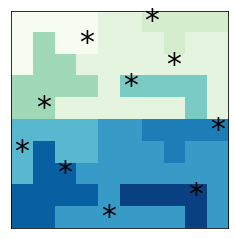

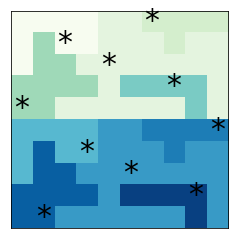

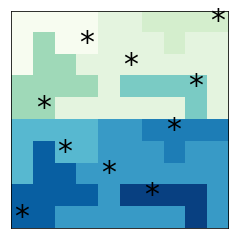

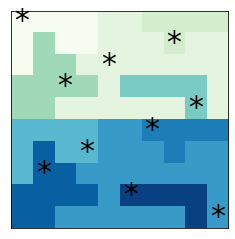

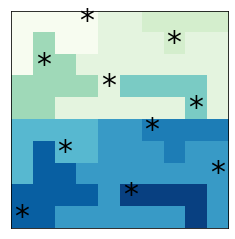

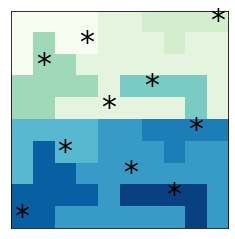

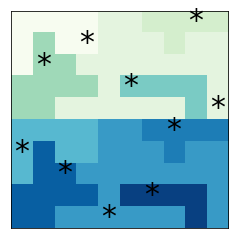

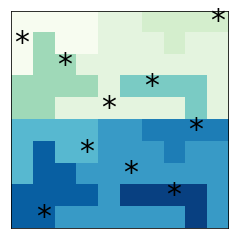

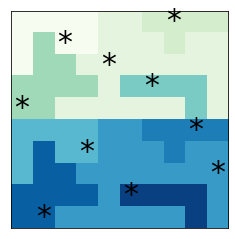

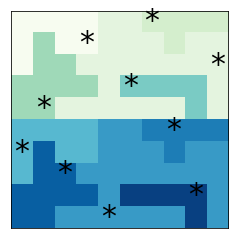

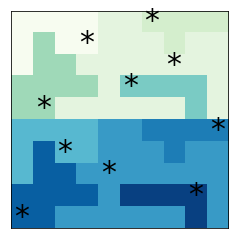

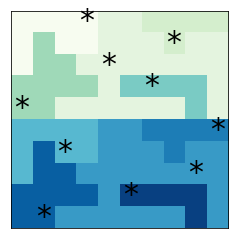

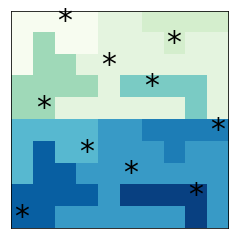

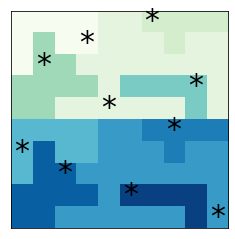

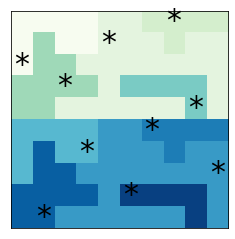

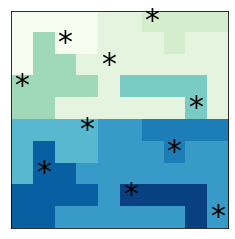

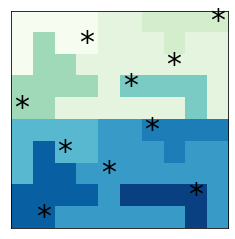

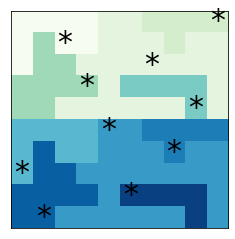

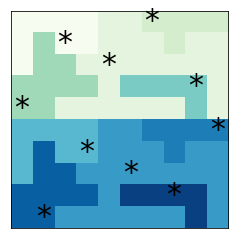

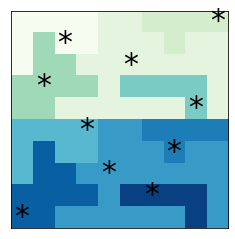

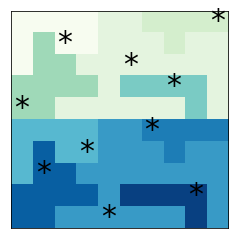

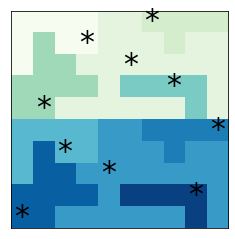

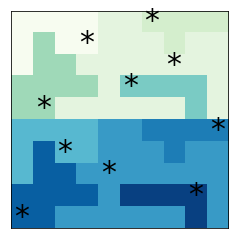

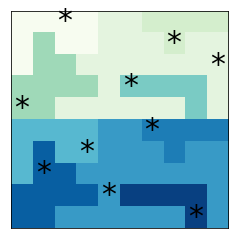

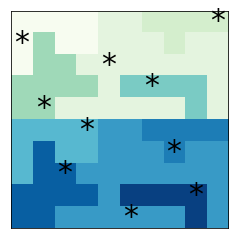

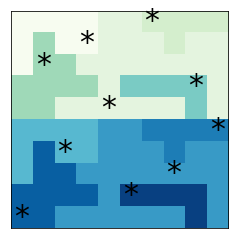

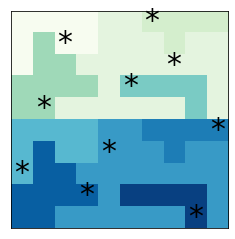

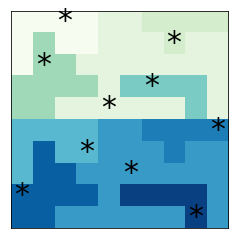

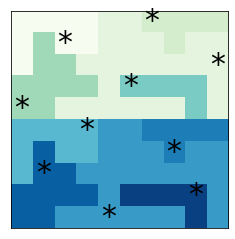

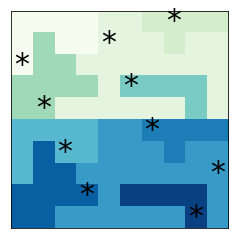

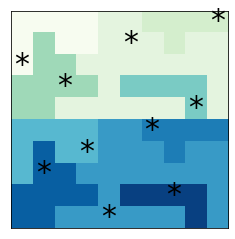

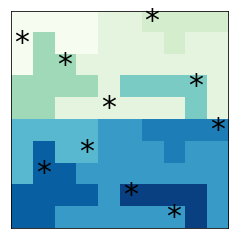

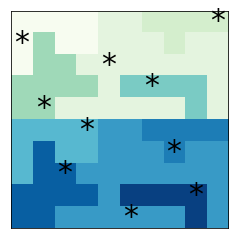

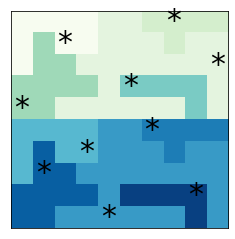

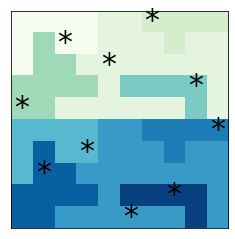

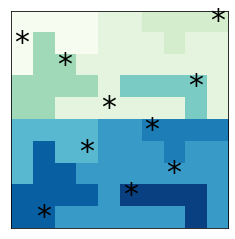

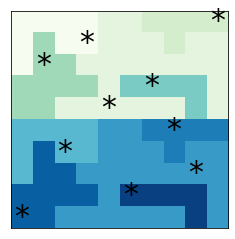

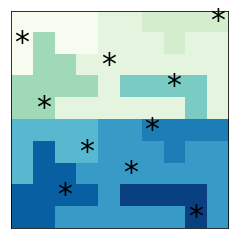

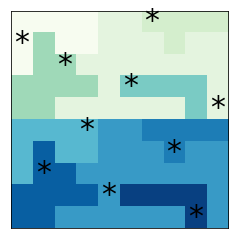

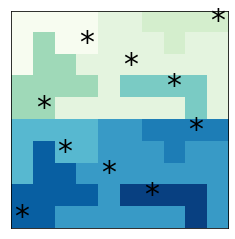

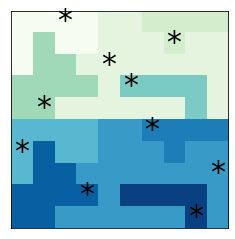

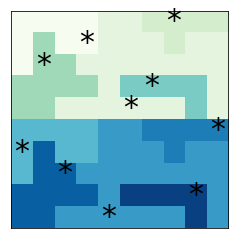

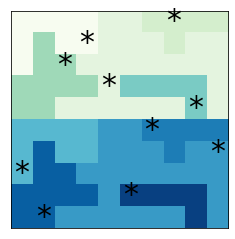

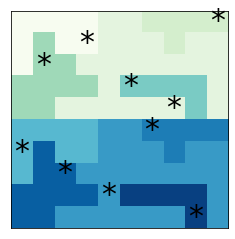

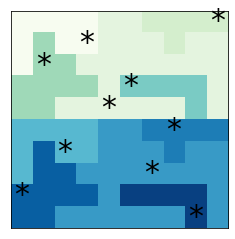

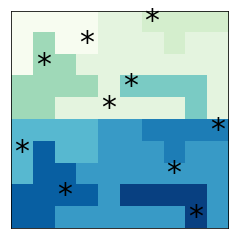

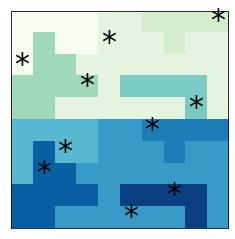

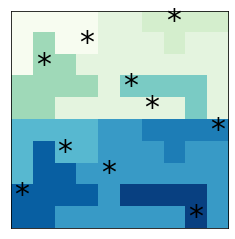

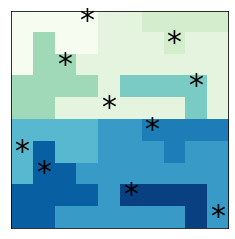

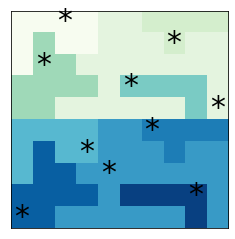

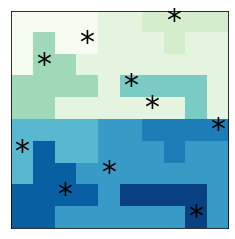

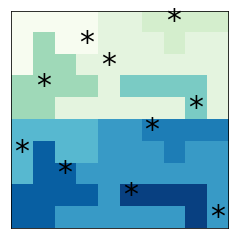

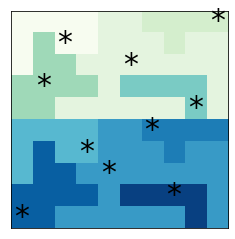

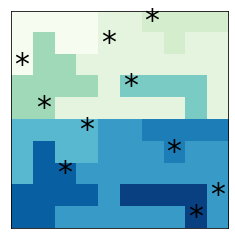

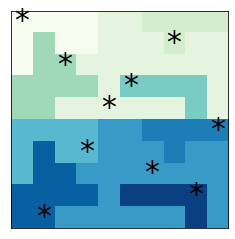

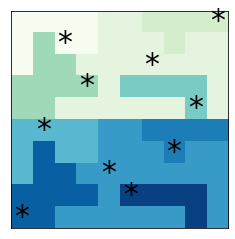

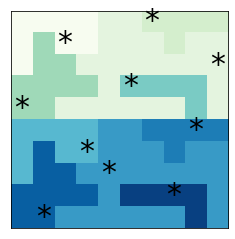

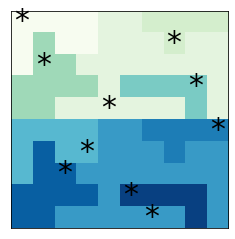

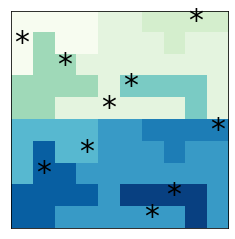

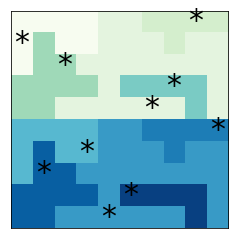

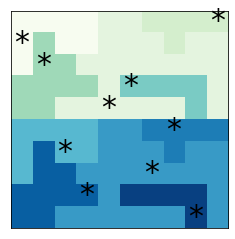

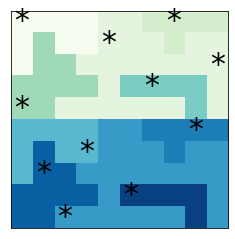

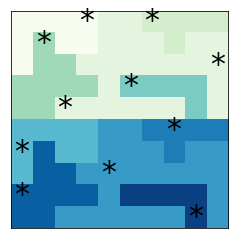

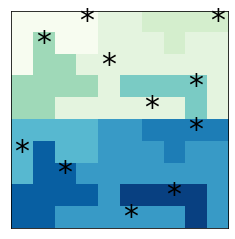

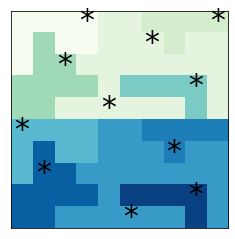

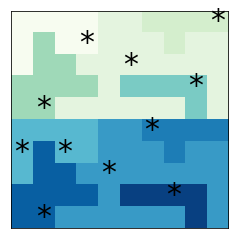

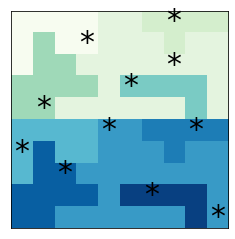

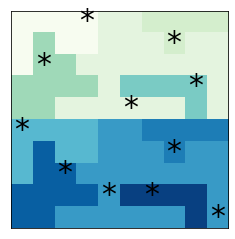

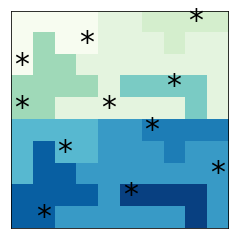

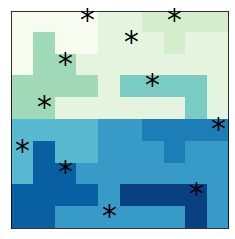

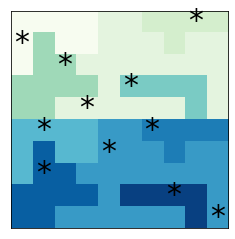

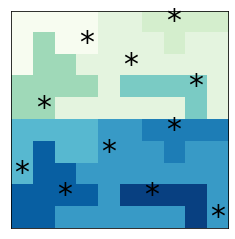

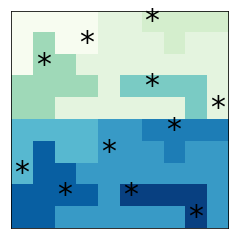

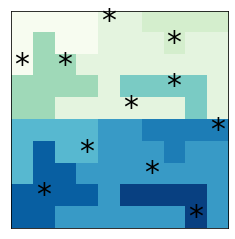

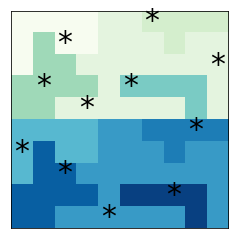

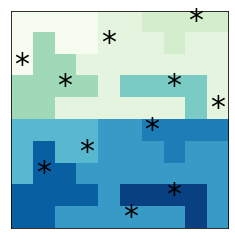

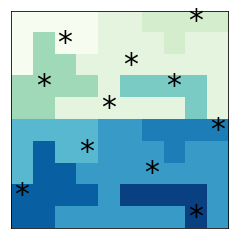

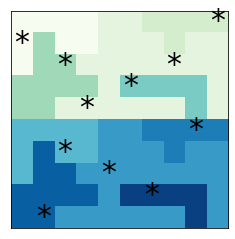

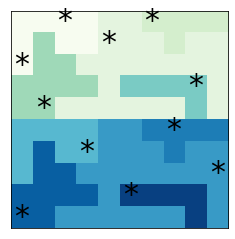

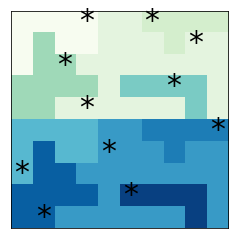

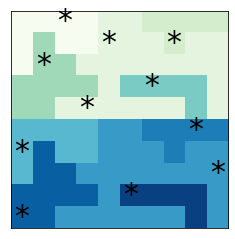

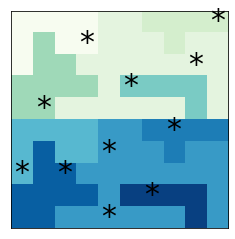

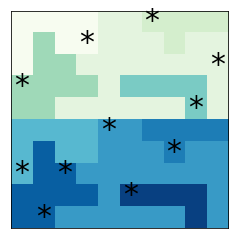

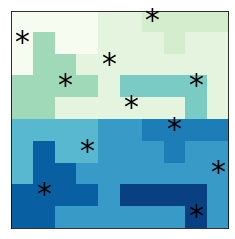

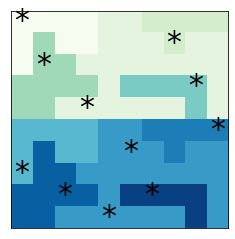

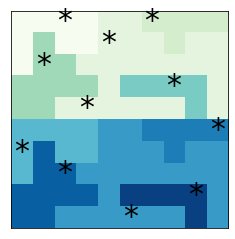

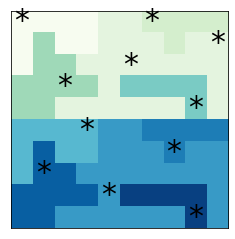

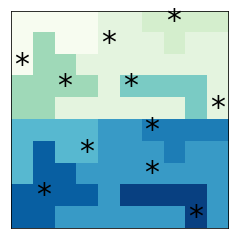

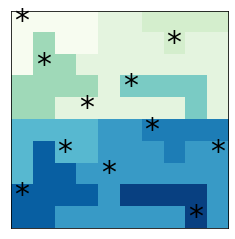

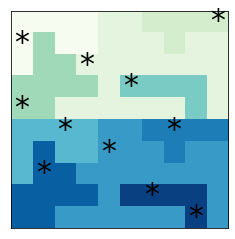

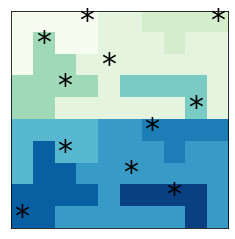

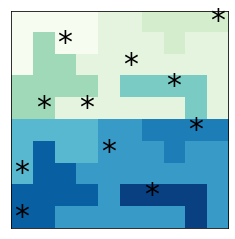

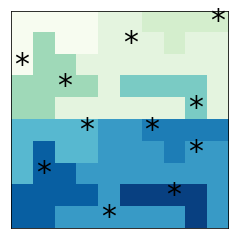

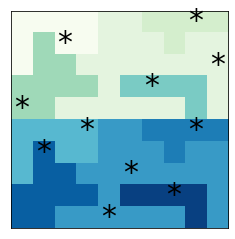

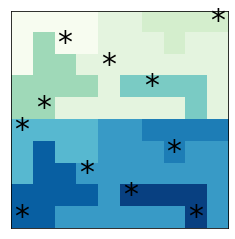

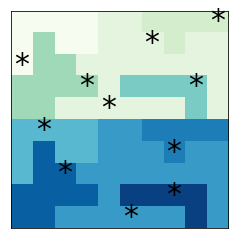

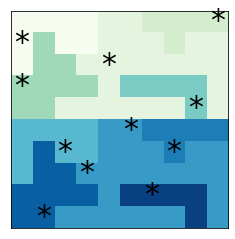

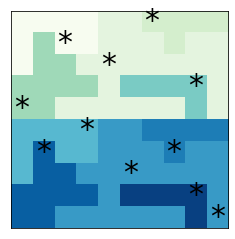

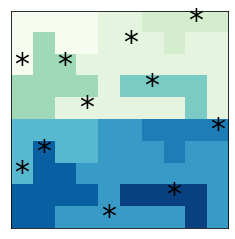

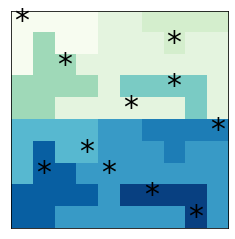

In [10]:
for sample in sampleset:
    # if confirm_solution(sample, regions, nstars):
        sample_to_plot(grid, sample)

In [19]:
confirm_solution(array_to_sample(star), regions, nstars)

False